In [40]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
from sklearn import cross_decomposition
from sklearn.model_selection import KFold

from neural_regression.datasets.Lieber_V4 import LieberV4
from neural_regression.datasets.transforms import LieberV4_ImageNet_Transform 
from neural_regression.models.alexnet import get_alexnet_model
from neural_regression.regression.activations import get_activations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# get models
alexnet_random = get_alexnet_model("random")
alexnet_supervised = get_alexnet_model("supervised")
alexnet_robust = get_alexnet_model("robust")

# create dataset
dataset = LieberV4(
    image_transform = LieberV4_ImageNet_Transform(),
)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4,
)

In [39]:
# get activations
layer_names = [
    'features.0',
    'features.1',
    'features.2',
    'features.3',
    'features.4',
    'features.5',
    'features.6',
    'features.7',
    'features.8',
    'features.9',
    'features.10',
    'features.11',
    'features.12',
]

activations_random, neural_responses, _ = get_activations(
    model = alexnet_random,
    loader = dataloader,
    result_layers = layer_names,
    device = torch.device("cuda"),
)

activations_supervised, _, _ = get_activations(
    model = alexnet_supervised,
    loader = dataloader,
    result_layers = layer_names,
    device = torch.device("cuda"),
)

activations_robust, _, _ = get_activations(
    model = alexnet_robust,
    loader = dataloader,
    result_layers = layer_names,
    device = torch.device("cuda"),
)

/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will 

/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will 

In [36]:
def simple_score_pls(X, Y, n_splits=5, num_components=25, scale=False):
    # flatten X if needed
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        pls = cross_decomposition.PLSRegression(n_components=num_components, scale=scale)
        pls.fit(X_train, Y_train)

        preditions_test = pls.predict(X_test)
        corrs = [
            np.corrcoef(Y_test[:, i], preditions_test[:, i])[0, 1] 
            for i in range(Y.shape[1])
        ]
        scores.append(np.median(corrs))

    return scores


In [37]:
scores_random = simple_score_pls(
    X = activations_random['features.12'],
    Y = neural_responses,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

scores_supervised = simple_score_pls(
    X = activations_supervised['features.12'],
    Y = neural_responses,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

scores_robust = simple_score_pls(
    X = activations_robust['features.12'],
    Y = neural_responses,
    n_splits = 5,
    num_components = 25,
    scale = False,
)

In [43]:
result_dict = {
    'layer': [],
    'model': [],
    'score': [],
}

for layer in tqdm(layer_names[2:]):
    scores_random_layer = simple_score_pls(
        X = activations_random[layer],
        Y = neural_responses,
        n_splits = 5,
        num_components = 25,
        scale = False,
    )

    scores_supervised_layer = simple_score_pls(
        X = activations_supervised[layer],
        Y = neural_responses,
        n_splits = 5,
        num_components = 25,
        scale = False,
    )

    scores_robust_layer = simple_score_pls(
        X = activations_robust[layer],
        Y = neural_responses,
        n_splits = 5,
        num_components = 25,
        scale = False,
    )

    result_dict['layer'].extend([layer] * 15)

    # random
    result_dict['model'].extend(['random'] * 5)
    result_dict['score'].extend(scores_random_layer)

    # supervised
    result_dict['model'].extend(['supervised'] * 5)
    result_dict['score'].extend(scores_supervised_layer)

    # robust
    result_dict['model'].extend(['robust'] * 5)
    result_dict['score'].extend(scores_robust_layer)

 36%|███████████████████████████████████████████████▎                                                                                  | 4/11 [04:14<06:57, 59.57s/it]/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
 45%|███████████████████████████████████████████████████████████                                                                       | 5/11 [05:00<05:27, 54.58s/it]/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reach

In [47]:
result_df = pd.DataFrame(result_dict)

# convert layer names to depth (integers)
layer_depth_map = {name: i + 1 for i, name in enumerate(layer_names)}
result_df['layer_depth'] = result_df['layer'].map(layer_depth_map)




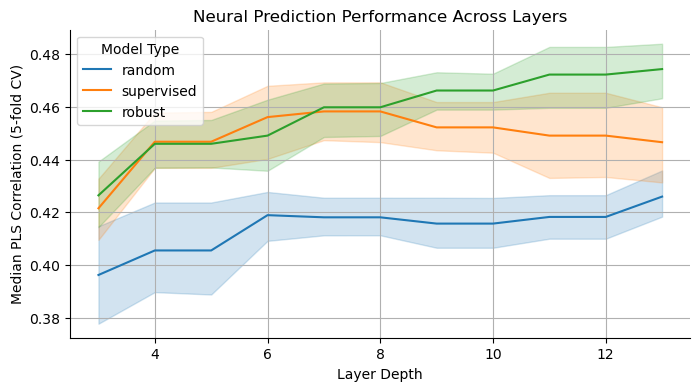

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sns.lineplot(
    data=result_df,
    x='layer_depth',
    y='score',
    hue='model',
    ax=ax
)

# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Layer Depth')
ax.set_ylabel('Median PLS Correlation (5-fold CV)')
ax.set_title('Neural Prediction Performance Across Layers')
ax.legend(title='Model Type')

ax.grid(True)

